<a href="https://colab.research.google.com/github/jansoe/ANNet/blob/main/Autoencoder_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a href="https://colab.research.google.com/github/jansoe/dl_workshop/blob/main/Autoencoderv2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import time
import numpy as np
import matplotlib.pyplot as plt
from IPython import display

In [ ]:
# Importing necessary PyTorch module
import torch
import torch.nn as nn
import torch.nn.functional as F

from torchvision import datasets, transforms

# Checking for GPU availability in PyTorch
torch.cuda.is_available()

True

# Autoencoder


In [ ]:
trainset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=True, transform=transforms.ToTensor())
testset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=False, transform=transforms.ToTensor())

100%|██████████| 9912422/9912422 [00:00<00:00, 225236399.34it/s]

Extracting /root/.pytorch/MNIST_data/MNIST/raw/train-images-idx3-ubyte.gz to /root/.pytorch/MNIST_data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 42593422.58it/s]

Extracting /root/.pytorch/MNIST_data/MNIST/raw/train-labels-idx1-ubyte.gz to /root/.pytorch/MNIST_data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 69798266.08it/s]


Extracting /root/.pytorch/MNIST_data/MNIST/raw/t10k-images-idx3-ubyte.gz to /root/.pytorch/MNIST_data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 18282657.17it/s]

Extracting /root/.pytorch/MNIST_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to /root/.pytorch/MNIST_data/MNIST/raw



Der MNIST-Datensatz besteht aus 60000 Trainingsbildern (und 10000 Testbildern)

In [ ]:
trainset

Dataset MNIST
    Number of datapoints: 60000
    Root location: /root/.pytorch/MNIST_data/
    Split: Train
    StandardTransform
Transform: ToTensor()

In [ ]:
sample_idx = 7


type(trainset[sample_idx])

img = trainset[sample_idx][0]
print(img.shape)

label = trainset[sample_idx][1]
print(label)

torch.Size([1, 28, 28])
3


Jeder Datenpunkt besteht aus einem Bild und dem zugehoerigen Label

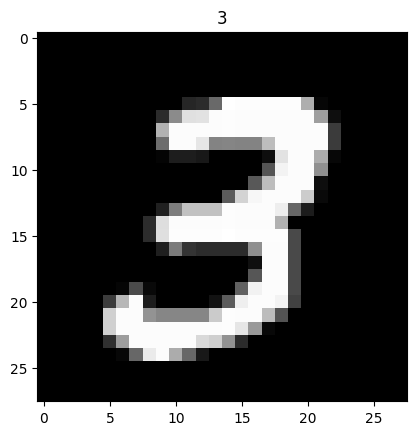

In [ ]:
sample_idx = 7
_ = plt.imshow(trainset[sample_idx][0].squeeze(), cmap=plt.cm.gray)
_ = plt.title(trainset[sample_idx][1])

## Encoder

The Encoder is similar to a classification network. Only there is no final classification head at the end.

In [ ]:
class Encoder(nn.Module):
    def __init__(self, latent_dim):
        super(Encoder, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=2, padding=1)
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(in_features=64 * 7 * 7, out_features=latent_dim)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.flatten(x)
        x = self.fc(x)
        return x

In [ ]:
encoder = Encoder(latent_dim = 8)

## Decoder

The Decoder is taking an input and reconstructing an image from this

In [ ]:
class Decoder(nn.Module):
    def __init__(self, latent_dim):
        super(Decoder, self).__init__()
        self.fc = nn.Linear(latent_dim, 7 * 7 * 32)
        self.conv_transpose1 = nn.ConvTranspose2d(32, 64, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.conv_transpose2 = nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.conv_transpose3 = nn.ConvTranspose2d(32, 1, kernel_size=3, stride=1, padding=1)

    def forward(self, x):
        x = F.relu(self.fc(x))
        x = x.view(-1, 32, 7, 7)  # Reshape to (batch_size, channels, height, width)
        x = F.relu(self.conv_transpose1(x))
        x = F.relu(self.conv_transpose2(x))
        x = torch.sigmoid(self.conv_transpose3(x))
        return x

In [ ]:
decoder = Decoder(latent_dim = 8)

## Autoencoder

Combining Encoder-Autoencoder



In [ ]:
class Autoencoder(nn.Module):
    def __init__(self, encoder, decoder):
        super(Autoencoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [ ]:
autoencoder = Autoencoder(encoder, decoder)

In [ ]:
autoencoder

Autoencoder(
  (encoder): Encoder(
    (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (flatten): Flatten(start_dim=1, end_dim=-1)
    (fc): Linear(in_features=3136, out_features=8, bias=True)
  )
  (decoder): Decoder(
    (fc): Linear(in_features=8, out_features=1568, bias=True)
    (conv_transpose1): ConvTranspose2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (conv_transpose2): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (conv_transpose3): ConvTranspose2d(32, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
)

initial model predictions

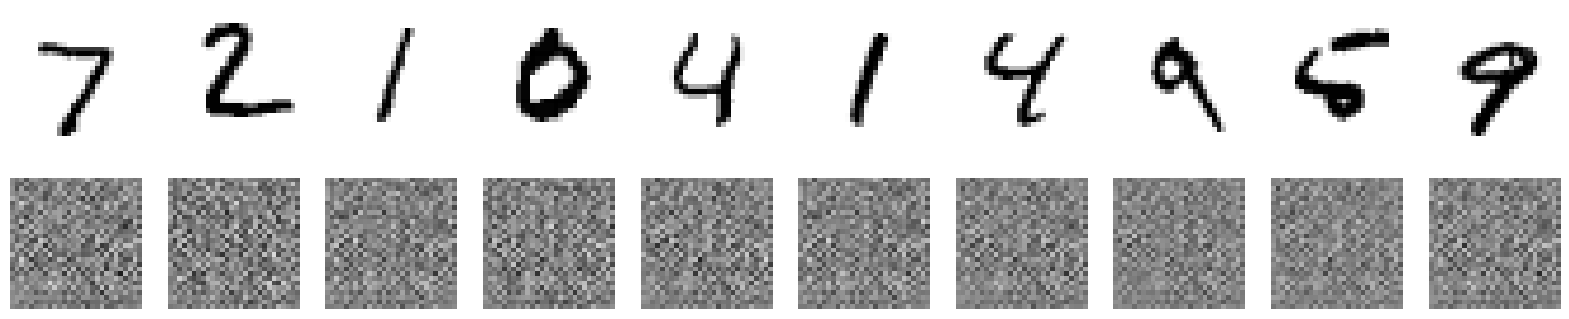

In [ ]:
n_plot = 10

fig, ax = plt.subplots(2, n_plot, figsize=(20, 4))
for i in range(n_plot):

    # display original
    orig_img = testset[i][0]
    ax[0, i].imshow(orig_img.squeeze(), cmap='gray_r', vmin=0, vmax=1)
    ax[0, i].axis('off')

    # display autoencoded
    with torch.no_grad():
        autoencoded_img = autoencoder(orig_img[None])
    ax[1, i].imshow(autoencoded_img.squeeze(), cmap='gray_r', vmin=0, vmax=1)
    ax[1, i].axis('off')

### Training



In [ ]:
loss_fn = nn.BCELoss()

optimizer = torch.optim.Adam(autoencoder.parameters(), lr=1e-3)

In [ ]:
train_loader = torch.utils.data.DataLoader(
    dataset=trainset,       # The dataset object to load data from
    batch_size=256,        # Number of samples per batch
    shuffle=True,           # Shuffle the dataset at every epoch
    num_workers=4           # Number of subprocesses to use for data loading (optional, depends on your system)
)


test_loader = torch.utils.data.DataLoader(
    dataset=testset,
    batch_size=256,
    shuffle=False,
    num_workers=4
)

In [ ]:
num_epochs = 40

for epoch in range(num_epochs):

    # Training phase
    autoencoder.train()
    train_loss = 0.0
    for data in train_loader:
        inputs, targets = data
        optimizer.zero_grad()
        outputs = autoencoder(inputs)
        loss = loss_fn(outputs, inputs)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    # Validation phase
    autoencoder.eval()
    val_loss = 0.0
    with torch.no_grad():
        for data in test_loader:
            inputs, targets = data
            outputs = autoencoder(inputs)
            loss = loss_fn(outputs, inputs)
            val_loss += loss.item()

    # Logging the losses
    print(f'Epoch {epoch+1}/{num_epochs} \t Training Loss: {train_loss/len(train_loader)} \t Validation Loss: {val_loss/len(test_loader)}')

Epoch 1/40 	 Training Loss: 0.20999598877227052 	 Validation Loss: 0.1454343345016241
Epoch 2/40 	 Training Loss: 0.13941595427533413 	 Validation Loss: 0.1333814537152648
Epoch 3/40 	 Training Loss: 0.13208055654738812 	 Validation Loss: 0.12941980585455895
Epoch 4/40 	 Training Loss: 0.12851335200223518 	 Validation Loss: 0.1256643423810601
Epoch 5/40 	 Training Loss: 0.1260002261463632 	 Validation Loss: 0.12407862860709429
Epoch 6/40 	 Training Loss: 0.12433465627279687 	 Validation Loss: 0.12290417142212391
Epoch 7/40 	 Training Loss: 0.12284544357594024 	 Validation Loss: 0.1222331641241908
Epoch 8/40 	 Training Loss: 0.12189266868728273 	 Validation Loss: 0.120450334623456
Epoch 9/40 	 Training Loss: 0.12082460842868115 	 Validation Loss: 0.11979458145797253
Epoch 10/40 	 Training Loss: 0.11994796785268377 	 Validation Loss: 0.11980451885610818
Epoch 11/40 	 Training Loss: 0.11944882219776194 	 Validation Loss: 0.11840823292732239
Epoch 12/40 	 Training Loss: 0.11863197858663316

ouput after the training

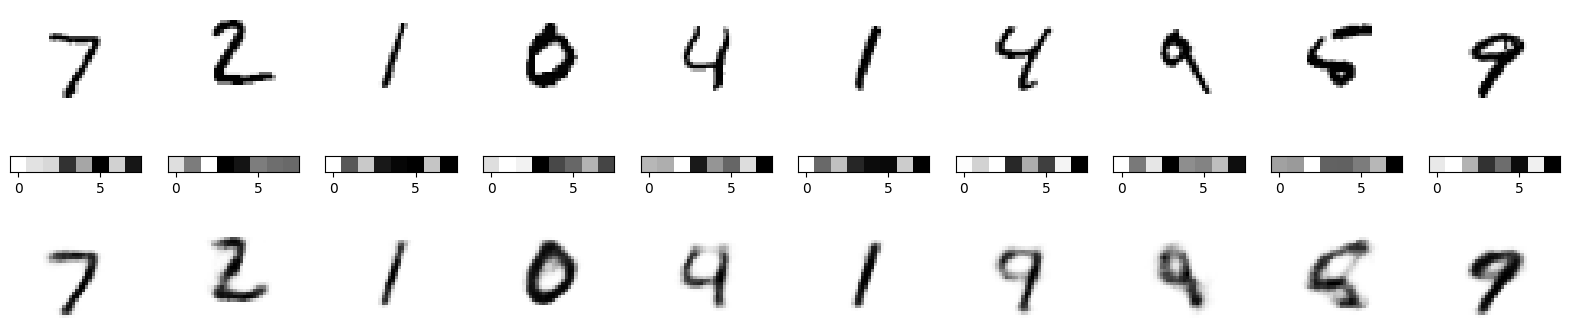

In [ ]:
n_plot = 10

fig, ax = plt.subplots(3, n_plot, figsize=(20, 4))
for i in range(n_plot):

    # display original
    orig_img = testset[i][0]
    ax[0, i].imshow(orig_img.squeeze(), cmap='gray_r')
    ax[0, i].axis('off')

    with torch.no_grad():
        encoded_img = encoder(orig_img[None])
    ax[1, i].imshow(encoded_img, cmap='gray_r')
    ax[1, i].set_yticks([])

    # display decoded
    with torch.no_grad():
        autoencoded_img = decoder(encoded_img[None])
    ax[2, i].imshow(autoencoded_img.squeeze(), cmap='gray_r')
    ax[2, i].axis('off')

### Aufgaben
1. Dimension des latenten Raumes
  - Verlgleichen Sie die Resultate für unterschiedlich große latente Räumen
    - Wieviele Dimensionen muss der latente Raum mindestens haben?

2. Rechnen im latenten Raum
  - Berechnen Sie die latente Darstellung für 2 Testbilder (encoded images)
  -  Erstellen Sie ein gewichtetes Mittel der beiden Embeddings  $\alpha \vec{e_1} + (1-\alpha) \vec{e_2}$ für verschiedene Werte von $\alpha$ zwischen 0 und 1
  - Dekodieren Sie nun wieder den gemittelten Code
  - Bonus: Wie sieht das Ergebniss aus, wenn man dieses gewichtete Mittel direkt im Pixelraum ausführt?